# Name: Tufan Kundu
# Reg no.: 24MDT0184
# DA3

# Outlier detection on synthetic data

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import chi2, zscore

### Generating synthetic data

In [2]:
# random seed for reproducibility
np.random.seed(42)

# Number of normal data points
n_samples = 600
mean = [0, 0]  # Mean of the distribution
cov = [[1, 0.5], [0.5, 1]]  # Covariance matrix

# Generate normal data
data_normal = np.random.multivariate_normal(mean, cov, n_samples)

# Inject outliers
n_outliers = 25
data_outliers = np.random.uniform(low=-3, high=3, size=(n_outliers, 2))

# Combine normal data and outliers
data_all = np.vstack([data_normal, data_outliers])

# Create DataFrame
df_synthetic = pd.DataFrame(data_all, columns=['Feature1', 'Feature2'])

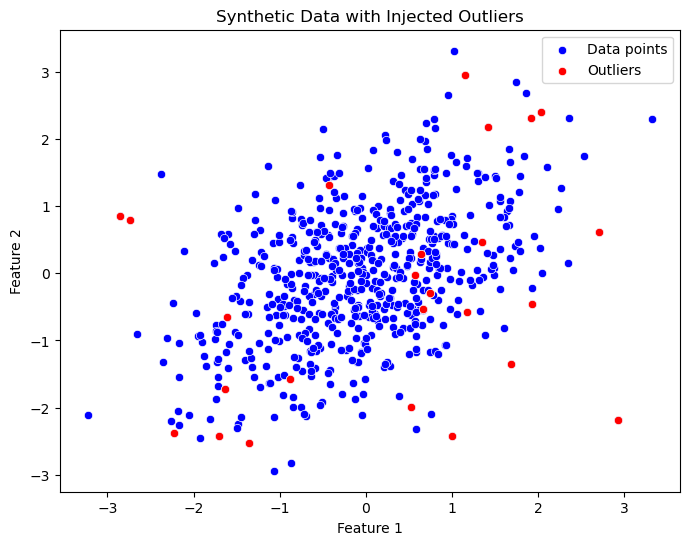

In [3]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Feature1', y='Feature2', data=df_synthetic, color='blue', label='Data points')
sns.scatterplot(x=data_outliers[:, 0], y=data_outliers[:, 1], color='red', label='Outliers')
plt.title("Synthetic Data with Injected Outliers")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

- Here we have created a synthetic data with 600 samples with 25 outliers

## Using Z score method to detect outliers

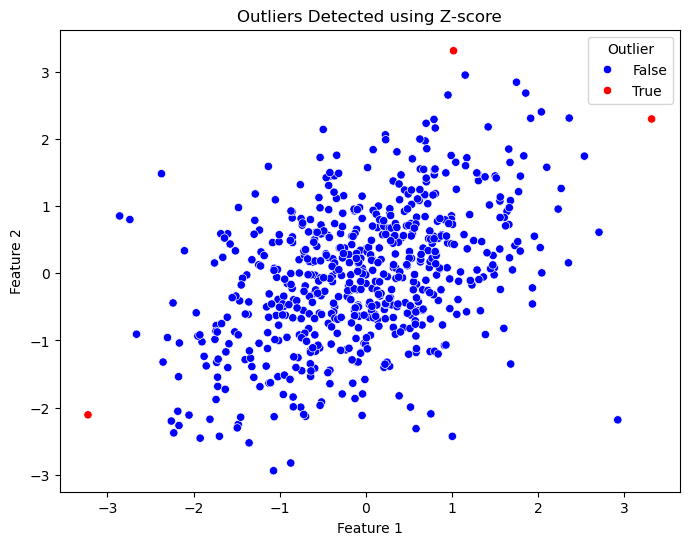

Z-score method detected outlier: 3


In [4]:
df_z = df_synthetic.copy()
df_z['Z_Score1'] = zscore(df_z['Feature1'])
df_z['Z_Score2'] = zscore(df_z['Feature2'])
df_z['Outlier_Z'] = (df_z['Z_Score1'].abs() > 3) | (df_z['Z_Score2'].abs() > 3)

# Plot Z-score detected outliers
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Feature1', y='Feature2', data=df_z, hue='Outlier_Z', palette={False: 'blue', True: 'red'})
plt.title("Outliers Detected using Z-score")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Outlier')
plt.show()
print("Z-score method detected outlier:",df_z['Outlier_Z'].sum())

## Using IQR Method

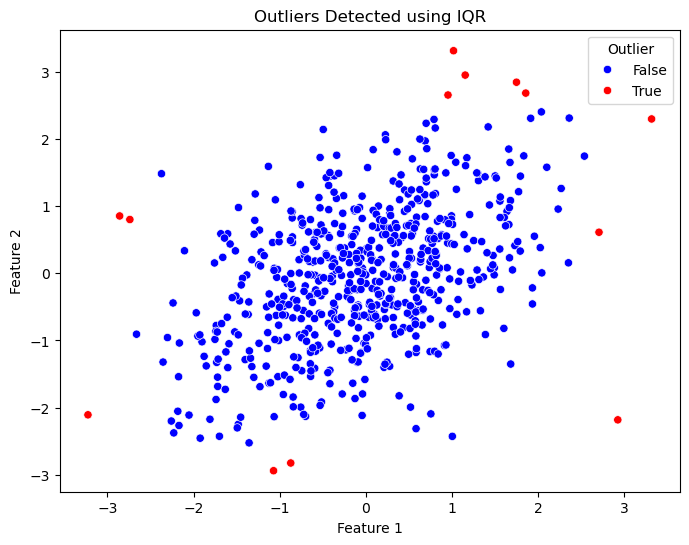

IQR method detected outlier: 13


In [5]:
Q1 = df_synthetic.quantile(0.25)
Q3 = df_synthetic.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_synthetic['Outlier_IQR'] = ((df_synthetic < lower_bound) | (df_synthetic > upper_bound)).any(axis=1)

# Plot IQR detected outliers
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Feature1', y='Feature2', data=df_synthetic, hue='Outlier_IQR', palette={False: 'blue', True: 'red'})
plt.title("Outliers Detected using IQR")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Outlier')
plt.show()

# print the number of outliers detected using the Z-score method
print("IQR method detected outlier:",df_synthetic['Outlier_IQR'].sum())

## KNN based outlier detection

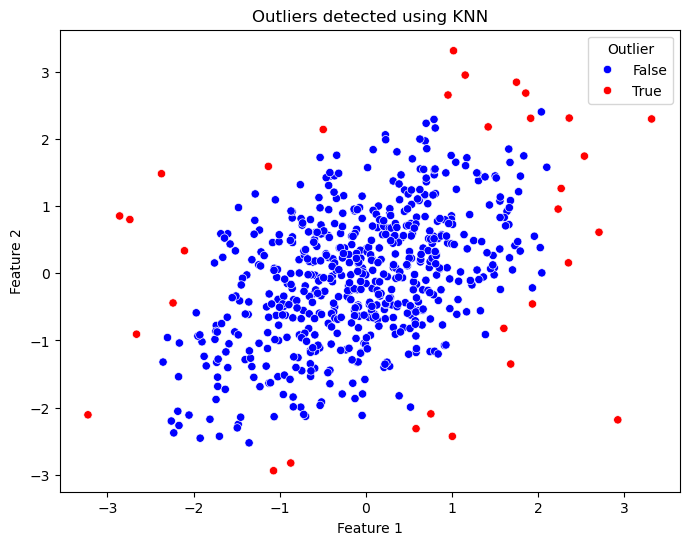

KNN method detected outliers: 32


In [6]:
# set the number of neighbours for the KNN method
k = 5

# Initialize and fit the NearestNeighbour model
# we use k+1 neighbour because the closest neighbour to a point is the point itself
nbrs = NearestNeighbors(n_neighbors=k+1)
nbrs.fit(df_synthetic[['Feature1','Feature2']])

# calculate the distance to the k-th nearest neighbour for each data point
distances, indices = nbrs.kneighbors(df_synthetic[['Feature1','Feature2']])

# Exclude the zero distance and compute the average distance to the k neighbours
avg_distance = distances[:,1:].mean(axis=1)

# Add a computed average KNN distance to the DataFrame
df_synthetic['Avg_Distance'] = avg_distance

# set a threshold for outlier detection based on the 95th percentile of the average distances.
threshold_knn = np.percentile(avg_distance,95)
# flag points as outliers if the average distance is above the threshold
df_synthetic['Outlier_KNN'] = df_synthetic['Avg_Distance'] > threshold_knn

# plot the KNN outlier detection results
plt.figure(figsize=(8,6))   
sns.scatterplot(x='Feature1',y='Feature2',data=df_synthetic,hue='Outlier_KNN',palette={False:'blue',True:'red'})
plt.title("Outliers detected using KNN")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title='Outlier')
plt.show()

print("KNN method detected outliers:",df_synthetic['Outlier_KNN'].sum())



## Mahalanobis Distance

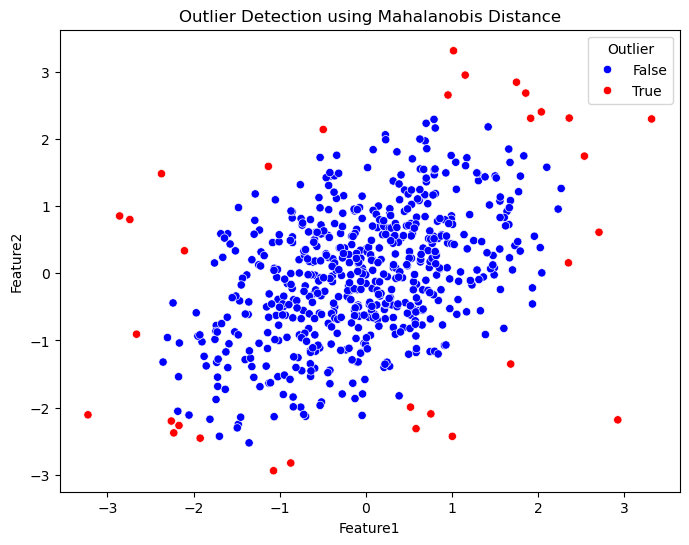

Mahalanobis method detected outliers: 32


In [7]:
def mahalanobis_distance(x=None, data=None, cov_inv=None):
    if cov_inv is None:
        cov = np.cov(data.T)
        cov_inv = np.linalg.inv(cov)
    x_minus_mu = x - np.mean(data, axis=0)
    left_term = np.dot(x_minus_mu, cov_inv)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal() if mahal.ndim > 0 else mahal

#Compute the covariance matrix for the features and then its inverse.
cov_matrix = np.cov(df_synthetic[['Feature1', 'Feature2']].values.T)
cov_inv = np.linalg.inv(cov_matrix)

#Compute Mahalanobis distances for all observations.
m_dist = []

#Calculate the mean of the features to center the data.
mean_df = df_synthetic[['Feature1', 'Feature2']].mean().values

#Iterate through each row (observation) in the DataFrame.
for i, row in df_synthetic[['Feature1', 'Feature2']].iterrows():
    #Calculate the difference between the observation and the mean.
    diff = row.values - mean_df

    #Compute the Mahalanobis distance for the observation.
    md = np.sqrt(np.dot(np.dot(diff.T, cov_inv), diff))

    m_dist.append(md)

#Add the Mahalanobis distances to the DataFrame.
df_synthetic['Mahalanobis_dist'] = m_dist

#Determine the threshold from the chi-square distribution.
#dof: degrees of freedom, which is equal to the number of features (2 in this case).
dof = 2
alpha = 0.95 #Confidence level for the threshold (95% quantile)

#Calculate the threshold value (square root because we compute Euclidean-like distances).
threshold_maha = np.sqrt(chi2.ppf(alpha, dof))

#Flag observations as outliers if their Mahalanobis distance exceeds the threshold.
df_synthetic['Outlier_Mahalanobis'] = df_synthetic['Mahalanobis_dist'] > threshold_maha

#Plot the results to visualize outliers detected by the Mahalanobis distance method.
plt.figure(figsize=(8, 6))

sns.scatterplot(x='Feature1', y='Feature2', data=df_synthetic, hue='Outlier_Mahalanobis', palette={False: 'blue', True: 'red'})
plt.title('Outlier Detection using Mahalanobis Distance')

plt.xlabel('Feature1')
plt.ylabel('Feature2')

plt.legend(title='Outlier')
plt.show()

#Print the number of outliers detected using the Mahalanobis method.
print("Mahalanobis method detected outliers:", df_synthetic['Outlier_Mahalanobis'].sum())

# Outlier detection on Iris dataset

In [8]:
from sklearn.datasets import load_iris
# Load Iris Dataset
iris = load_iris()
# Creating a DataFrame with feature names
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
# Standardizing the dataset
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.iloc[:, :-1]), columns=iris.feature_names)


## Using zscore method (without PCA)

In [9]:
df_s = df_scaled.copy()
# Compute Z-score for all features
df_s['Outlier_Z'] = (np.abs(zscore(df_s)) > 3).any(axis=1)

# Print number of outliers detected using Z-score
print("Z-score method detected outliers (Without PCA):", df_s['Outlier_Z'].sum())


Z-score method detected outliers (Without PCA): 1


## using IQR method without PCA

In [10]:

# Compute Q1 and Q3 for each feature
Q1 = df_scaled.quantile(0.25)
Q3 = df_scaled.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
df_scaled['Outlier_IQR'] = ((df_scaled < lower_bound) | (df_scaled > upper_bound)).any(axis=1)

# Print number of outliers detected using IQR
print("IQR method detected outliers (Without PCA):", df_scaled['Outlier_IQR'].sum())



IQR method detected outliers (Without PCA): 4


In [11]:
# PCA Transformation
features = iris.feature_names
x = df.loc[:, features].values
x_std = scaler.fit_transform(x)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x_std)

principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# ---------------------- 5. Z-Score Method After PCA ----------------------
pdf = principal_df.copy() 
pdf['Outlier_Z'] = (np.abs(zscore(pdf[['PC1', 'PC2']])) > 3).any(axis=1)

print("Z-score method detected outliers (After PCA):", pdf['Outlier_Z'].sum())

# ---------------------- 6. IQR Method After PCA ----------------------

Q1_pca = principal_df[['PC1', 'PC2']].quantile(0.25)
Q3_pca = principal_df[['PC1', 'PC2']].quantile(0.75)
IQR_pca = Q3_pca - Q1_pca

# Define lower and upper bounds
lower_bound_pca = Q1_pca - 1.5 * IQR_pca
upper_bound_pca = Q3_pca + 1.5 * IQR_pca

# Identify outliers based on IQR
principal_df['Outlier_IQR'] = ((principal_df[['PC1', 'PC2']] < lower_bound_pca) | 
                               (principal_df[['PC1', 'PC2']] > upper_bound_pca)).any(axis=1)

# Print number of outliers detected using IQR after PCA
print("IQR method detected outliers (After PCA):", principal_df['Outlier_IQR'].sum())


Z-score method detected outliers (After PCA): 0
IQR method detected outliers (After PCA): 4


In [12]:
# ---------------------- 7. KNN Method ----------------------

k = 5
nbrs = NearestNeighbors(n_neighbors=k+1)
nbrs.fit(df.iloc[:, :-1])

# Compute KNN distances
distances, indices = nbrs.kneighbors(df.iloc[:, :-1])
avg_distance = distances[:, 1:].mean(axis=1)

df['Avg_Distance'] = avg_distance
threshold_knn = np.percentile(avg_distance, 95)
df['Outlier_KNN'] = df['Avg_Distance'] > threshold_knn

print("KNN method detected outliers (Without PCA):", df['Outlier_KNN'].sum())

# ---------------------- 8. KNN Method After PCA ----------------------

nbrs.fit(principal_df[['PC1', 'PC2']])

# Compute KNN distances
distances, indices = nbrs.kneighbors(principal_df[['PC1', 'PC2']])
avg_distance = distances[:, 1:].mean(axis=1)

principal_df['Avg_Distance'] = avg_distance
threshold_knn = np.percentile(avg_distance, 95)
principal_df['Outlier_KNN'] = principal_df['Avg_Distance'] > threshold_knn

print("KNN method detected outliers (After PCA):", principal_df['Outlier_KNN'].sum())

# ---------------------- 9. Mahalanobis Distance (Before PCA) ----------------------

cov_matrix = np.cov(df.iloc[:, :-2].values.T)
cov_inv = np.linalg.inv(cov_matrix)

m_dist = []
mean_df = df.iloc[:, :-2].mean().values

for _, row in df.iloc[:, :-2].iterrows():
    diff = row.values - mean_df
    md = np.sqrt(np.dot(np.dot(diff.T, cov_inv), diff))
    m_dist.append(md)

df['Mahalanobis_Dist'] = m_dist

threshold_maha = np.sqrt(chi2.ppf(0.95, df=4))
df['Outlier_Mahalanobis'] = df['Mahalanobis_Dist'] > threshold_maha

print("Mahalanobis method detected outliers (Without PCA):", df['Outlier_Mahalanobis'].sum())

# ---------------------- 10. Mahalanobis Distance (After PCA) ----------------------

cov_matrix_pca = np.cov(principal_df[['PC1', 'PC2']].values.T)
cov_inv_pca = np.linalg.inv(cov_matrix_pca)

m_dist_pca = []
mean_pca = principal_df[['PC1', 'PC2']].mean().values

for _, row in principal_df[['PC1', 'PC2']].iterrows():
    diff_pca = row.values - mean_pca
    md_pca = np.sqrt(np.dot(np.dot(diff_pca.T, cov_inv_pca), diff_pca))
    m_dist_pca.append(md_pca)

principal_df['Mahalanobis_Dist'] = m_dist_pca

threshold_maha_pca = np.sqrt(chi2.ppf(0.95, df=2))
principal_df['Outlier_Mahalanobis'] = principal_df['Mahalanobis_Dist'] > threshold_maha_pca

print("Mahalanobis method detected outliers (After PCA):", principal_df['Outlier_Mahalanobis'].sum())


KNN method detected outliers (Without PCA): 8
KNN method detected outliers (After PCA): 8
Mahalanobis method detected outliers (Without PCA): 16
Mahalanobis method detected outliers (After PCA): 6


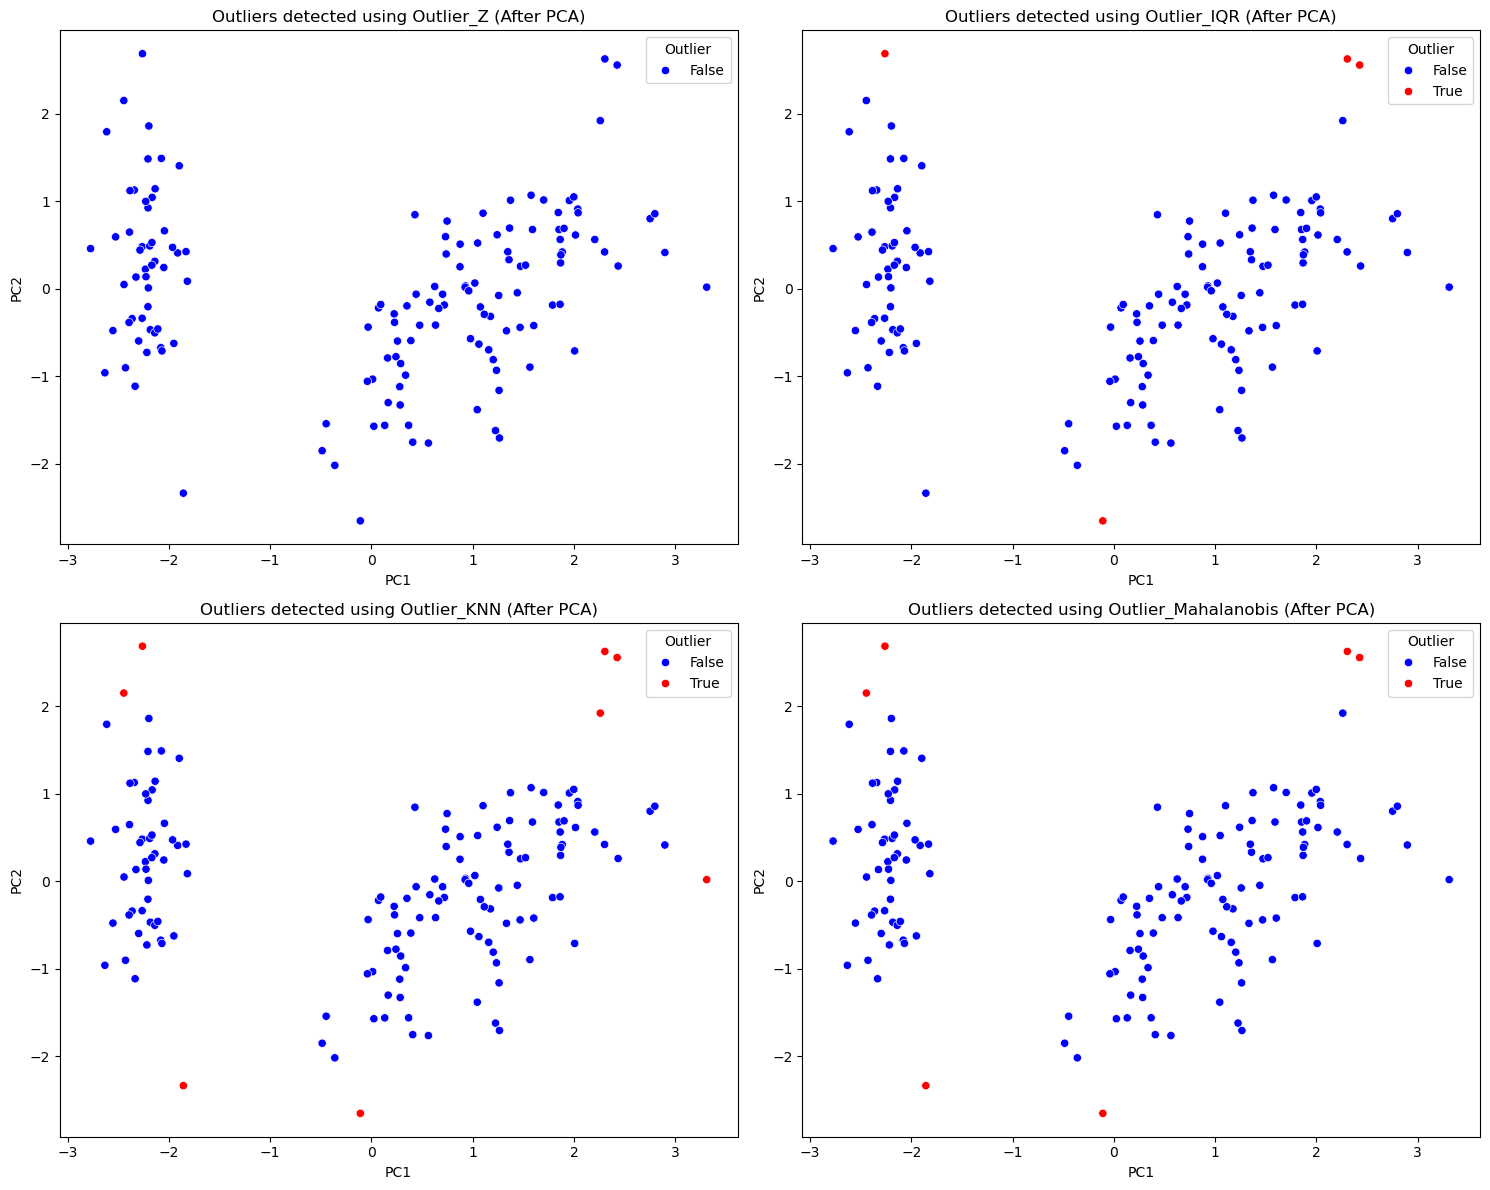

In [13]:
principal_df['Outlier_Z'] = pdf['Outlier_Z']
# ---------------------- 11. Visualizations ----------------------

methods = ['Outlier_Z', 'Outlier_IQR', 'Outlier_KNN', 'Outlier_Mahalanobis']

plt.figure(figsize=(15, 12))

for i, method in enumerate(methods, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x='PC1', y='PC2', data=principal_df, hue=principal_df[method], palette={False: 'blue', True: 'red'})
    plt.title(f"Outliers detected using {method} (After PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title='Outlier')

plt.tight_layout()
plt.show()

## Conclusion  

- Outlier Detection Methods:
  - Z-score and IQR work well for detecting outliers in individual features but are not effective for multivariate data.
  - KNN and Mahalanobis Distance consider feature relationships and perform better for detecting multivariate outliers.

- Comparison Before and After PCA:
  - Before PCA: More outliers were detected, but some were false positives due to the high-dimensional space.
  - After PCA: Fewer outliers were detected, but the results were more reliable.
  - Mahalanobis and KNN performed better after PCA, as they benefited from reduced dimensionality and noise.

- Why PCA Helps in Outlier Detection?:
  - High-dimensional data makes distance-based methods less effective.
  - Outlier detection becomes faster after dimensionality reduction.
  - PCA eliminates correlated features, reducing noise in outlier detection.

- PCA significantly improves the accuracy and efficiency of outlier detection, especially for multivariate datasets.